In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Read each csv into list, tumor
filepathTumor = 'E:\\TimeIntensityData\\04-12-19(in-tumor)\\'
filenamesTumor = ['0V','4V','8p8V','16p1V','25p8V']
datTumor = [pd.read_csv(filepathTumor + 'TimeIntensity' + name + '.csv') for name in filenamesTumor]

In [4]:
# Read each csv into list, muscle, new location only
filepathMuscle = 'E:\\TimeIntensityData\\04-16-19(in-muscle-only)\\newLoc\\'
filenamesMuscle = ['0V','4V','8p8V','16p1V','25p8V']
datMuscle = [pd.read_csv(filepathMuscle + 'newLoc' + name + '.csv') for name in filenamesMuscle]

# Normalized Pixel Intensity vs. Time, Focused Ultrasound Only

Oddly enough, FUS produced a response even in previously untouched tumors without a droplet injection. An obvious decrease in pixel intensity was observed shortly after initiating insonation in a dose-dependent manner (here, dose being pressure). I initially thought this was lodged bubbles being pushed out of the imaging slice or perhaps being burst, but it appears to be inherent to the tumor. Not sure what causes this - liquefactive necrotic regions being pushed to one side, red blood cells being pushed up or downstream in a vessel, or maybe the imaging is undersampling some FUS-induced vibrations in the tissue. Not entirely sure. Could this somehow be used to investigate tissue properties, e.g., fractional tumor necrosis, or another method of elastography if related to stiffness?

The resurgence is also odd, and the final intensity at the plateau appears to be dose-dependent as well.

These data were generated in real-time during imaging/insonation using the L7-4FASCgADV script with the new 'Plot Time-Int' feature I recently finished. All data was collected on the same tumor plane in the same mouse.

<IPython.core.display.Javascript object>


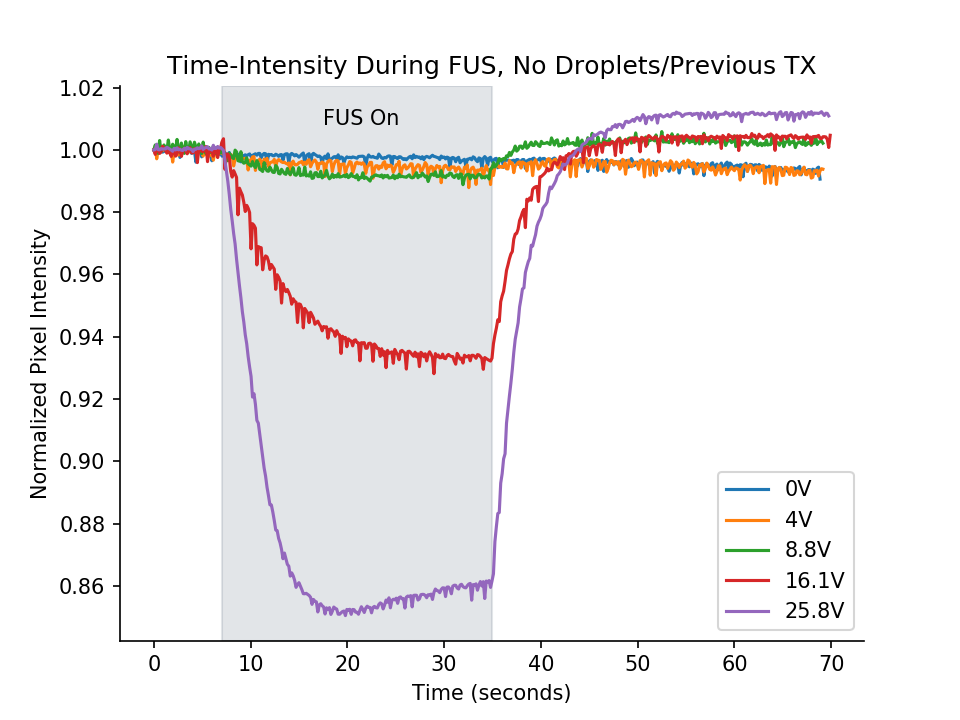

In [6]:
# Generate plot
%matplotlib notebook

fig, ax = plt.subplots(1,1)

# Remove spines
ax.spines['top'].set_visible(0)
ax.spines['right'].set_visible(0)

# Normalize intensity and plot
i = 0
for df in datTumor:
    df['AdjustedIntensity'] = df['Intensity']/df.loc[0,'Intensity']
    ax.plot(df['Time (s)'], df['AdjustedIntensity'], label=filenamesTumor[i].replace('p', '.'))
    i+=1

# Mark FUS On time period
ax.axvspan(7, 35, alpha = 0.2, color = 'slategrey')
ax.text(17.5, 1.008, 'FUS On')
    
# Label plot
plt.legend()
plt.title('Time-Intensity During FUS, No Droplets/Previous TX')
plt.xlabel('Time (seconds)')
plt.ylabel('Normalized Pixel Intensity')

# Save plot
plt.savefig(filepathTumor + 'Time-Intensity, FUS Only.jpg', dpi = 300)

In addition to this odd behavior, there was also one small region in which intensity obviously increased! This is similar to cases during attempted treatment, which I thought could be attributed to ADV, but this also seems to be inherent to the tumor. While some of the cases observed during treatment were obviously ADV-induced (e.g., rapid intensity increases from large pockets of bubbles being generated or slow intensity increases across the entire tumor), some of the more localized, slow intensity increases may not have been bubbles after all.

Note the initial decrease as well. I used a far smaller ROI for this, so the intensity increase dominates. The remainder of the tumor still showed the same decrease as in the previous figure, and appeared to be masking this local increase.

<IPython.core.display.Javascript object>


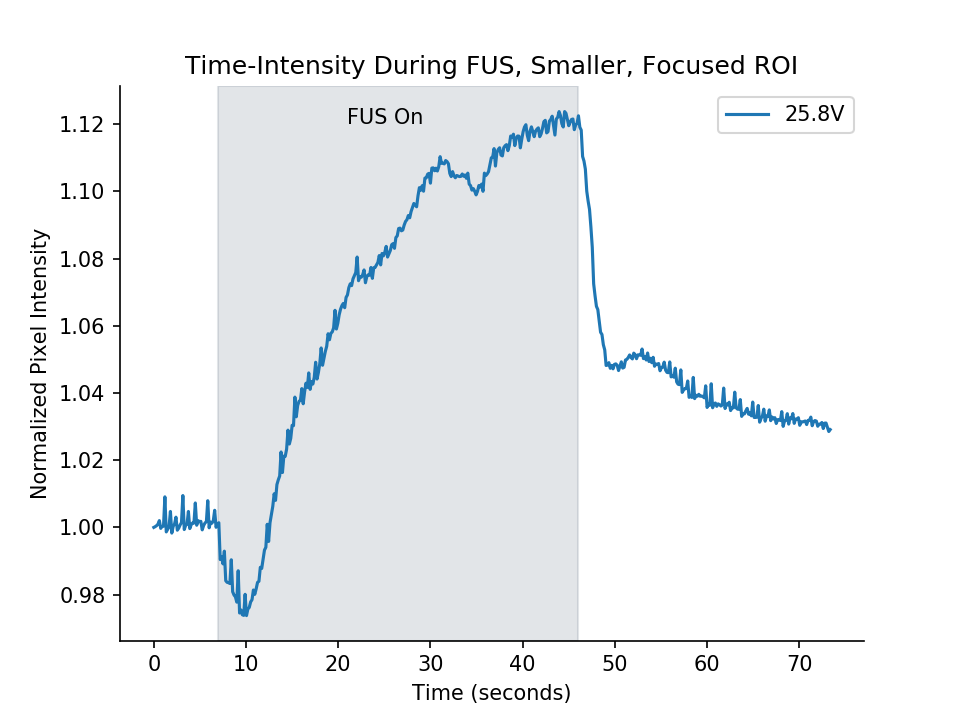

In [7]:
# Read in data
datSpot = pd.read_csv(filepathTumor + 'TimeIntensity25p8V_smallROI_BrightSpot.csv')

# Generate plot
fig, ax = plt.subplots(1,1)

# Remove spines
ax.spines['top'].set_visible(0)
ax.spines['right'].set_visible(0)

# Normalize intensity and plot
datSpot['AdjustedIntensity'] = datSpot['Intensity']/datSpot.loc[0,'Intensity']
ax.plot(datSpot['Time (s)'], datSpot['AdjustedIntensity'], label='25.8V')

# Mark FUS On time period
ax.axvspan(7, 46, alpha = 0.2, color = 'slategrey')
ax.text(21, 1.12, 'FUS On')
    
# Label plot
plt.legend()
plt.title('Time-Intensity During FUS, Smaller, Focused ROI')
plt.xlabel('Time (seconds)')
plt.ylabel('Normalized Pixel Intensity')

# Save plot
plt.savefig(filepathTumor + 'Time-Intensity, FUS Only, Bright Spot.jpg', dpi = 300)

Decided to check this out in muscle only in another mouse to see if the response was tissue-dependent. A subplot comparing the values in the tumor to the values in the muscle has been generated. It appears that the data from the muscle is far noisier, likely due to the fact that the ROI was drawn near a bright skin boundary that was probably being pulled in with each breath. Unfortunately, this is the data I'm stuck with for now. However, the trend is still clear - the tumor showed a larger response.

Decided to smooth both with a median filter; seems to do a pretty good job of eliminating the breathing noise in both cases.

In [45]:
def medFiltTimeSeries(dat, windowSize):
    filteredDat = []
    for i in range(len(dat)-windowSize):
        filteredDat.append(np.median(dat[i:i+windowSize]))
        
    return filteredDat

<IPython.core.display.Javascript object>


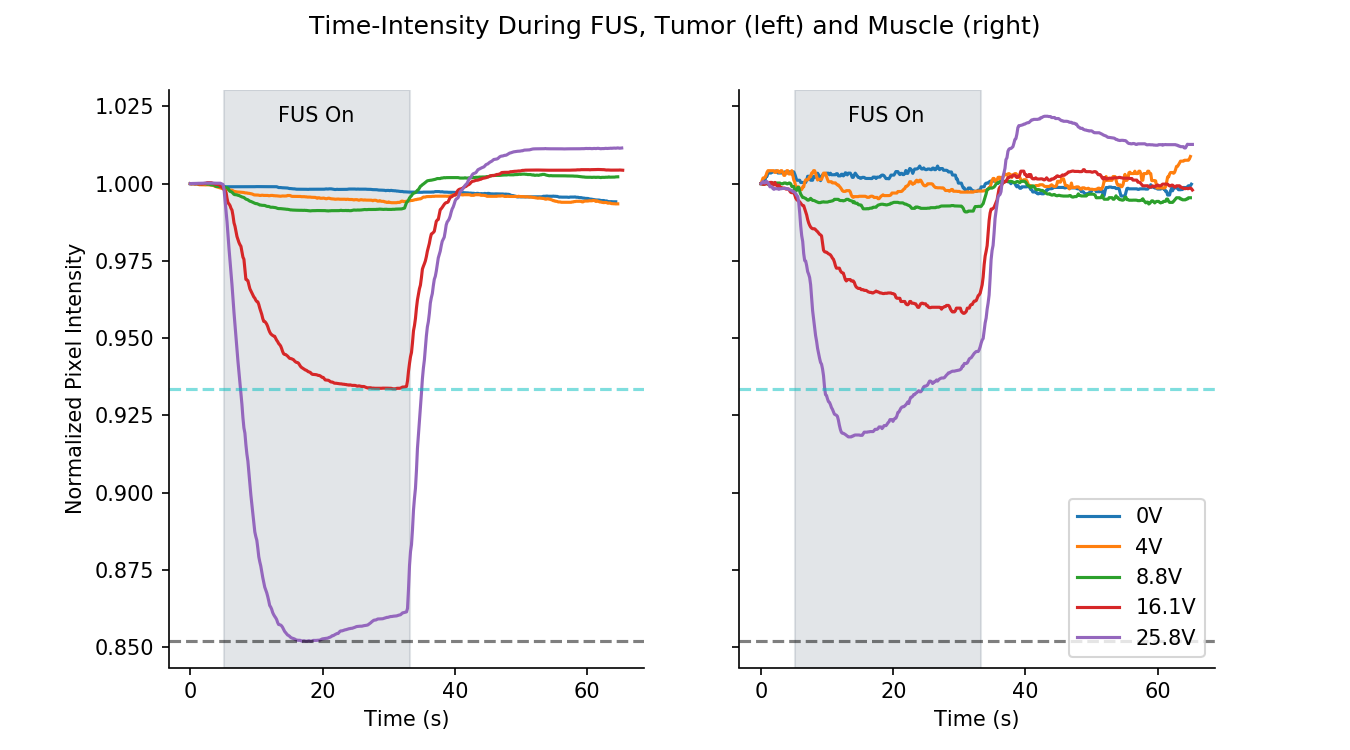

In [97]:
# Generate plot
%matplotlib notebook

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize = (9, 5))

# Remove spines
for ax in axs:
    ax.spines['top'].set_visible(0)
    ax.spines['right'].set_visible(0)

# Normalize intensity and plot, tumor values
windSize = 30
i = 0
minVals = []
for df in datTumor:
    intFilt = medFiltTimeSeries(df['Intensity'], windSize)
    adjInt = intFilt/intFilt[0]
    minVals.append(adjInt.min())
    
    axs[0].plot(df.loc[0:len(df)-windSize-1, 'Time (s)'], adjInt)
    
    i+=1
    
axs[0].set_ylabel('Normalized Pixel Intensity')
    
# Normalize intensity and plot, muscle; normalizing on second point since first point is spike
# for 0V
i = 0
for df in datMuscle:
    intFilt = medFiltTimeSeries(df['Intensity'], windSize)
    adjInt = intFilt/intFilt[0]
    df['AdjustedIntensity'] = df['Intensity']/df.loc[1,'Intensity']
    axs[1].plot(df.loc[0:len(df)-windSize-1, 'Time (s)'], adjInt, 
                label=filenamesMuscle[i].replace('p', '.'))
    i+=1

# Mark FUS On time period
for ax in axs:
    ax.axvspan(5.1, 33.2, alpha = 0.2, color = 'slategrey')
    ax.text(13.2, 1.02, 'FUS On')
    ax.set_xlabel('Time (s)')
    
# Mark levels of 16.1 and 25.8V in tumor with hlines for comparison w/ muscle
for ax in axs:
    ax.axhline(minVals[-2], alpha=0.5, linestyle = '--', color='c')
    ax.axhline(minVals[-1], alpha=0.5, linestyle = '--', color='k')
    
# Label plot
axs[1].legend(loc='lower right')
plt.suptitle('Time-Intensity During FUS, Tumor (left) and Muscle (right)')

# Save plot
plt.savefig(filepathMuscle + 'Time-Intensity, FUS Only, Tumor (left) and Muscle (right).jpg', dpi = 300)